# QMMM workflow using LAMMPS and VOTCA-XTP

## What is this tutorial about
In this tutorial, we will learn how to set and perform excited state calculation using the Votca XTP library. We will use thiophene as our QM region.

## Requirements
* You will need to install **VOTCA** using the instructions described [here](https://github.com/votca/votca/blob/master/share/doc/INSTALL.rst)
* Once the installation is completed you need to activate the VOTCA enviroment by running the `VOTCARC.bash` script that has been installed at the bin subfolder for the path that you have provided for the installation step above

## Interacting with the XTP command line interface
The XTP package offers the following command line interface that the user can interact with:
* [xtp_map](https://www.votca.org/xtp/xtp_map.html)
* [xtp_parallel](https://www.votca.org/xtp/xtp_parallel.html)
* [xtp_run](https://www.votca.org/xtp/xtp_run.html)
* [xtp_tools](https://www.votca.org/xtp/xtp_tools.html)

Run the following command to view the help message of `xtp_tools`:

In [1]:
!xtp_tools -h

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Runs excitation/charge transport tools



Allowed options:
  -h [ --help ]                 display this help and exit
  --verbose                     be loud and noisy
  --verbose1                    be very loud and noisy
  -v [ --verbose2 ]             be extremly loud and noisy
  -o [ --options ] arg          Tool user options.
  -t [ --nthreads ] arg (=1)    number of threads to create
  -e [ --execute ] arg        Name of Tool to run
  -l [ --list ]               Lists all available Tools
  -d [ --description ] arg    Short description of a Tools
  -c [ --cmdoptions ] arg     Modify options via command line by e.g. '-c 
                         

### Note
> * In Jupyter the `!` symbol means: *run the following command as a standard unix command*
> * In Jupyter the command `%env` set an environmental variable

## Setting the environment


Remove previous hdf5 file

In [2]:
!rm -f state.hdf5

## Generate the topology from the Gromacs file
We will first generate the mapping from MD coordinates to segments, creating an [hdf5 file](https://www.hdfgroup.org/solutions/hdf5/) to store the results. You can explore the generated `state.hdf5` file with e.g. hdf5itebrowser. In Python, you can use the [h5py library](https://www.h5py.org/). The command to generate the mapping is the following,

In [3]:
!xtp_map -v -t MD_FILES/newfile.data -c MD_FILES/traj.dump -s system.xml -f state.hdf5 -i 99 > mapping.out

##  Check the mapping

Let us first output `.pdb` files for the segments, qmmolecules and classical segments in order to check the mapping. So we have to pass the calculator the filename. Votca has two ways to specify options for calculators. Using a file with the `-o` option or for quick things using the `-c` option on the command line, we will use both.

In the [mapchecker section of the manual](https://www.votca.org/xtp/mapchecker.html) you can find a table with the `mapchecker` input variables and their corresponding defaults. Finally, the following command run the check

In [4]:
!xtp_run -e mapchecker -c map_file=system.xml -f state.hdf5

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_run, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... mapchecker
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... mapchecker
 Using 1 threads
Writing segments to md_segments_step_10000.pdb
Writing qmmolecules to qm_segments_n_step_10000.pdb
Writing polarsegments to mp_segments_e_step_10000.pdb
Writing polarsegments to mp_segments_h_step_10000.pdb
Changes have not been written to state file.


## Neighborlist Calculation
The following step is to determine the neighbouring pairs for exciton transport.

We will use a cutoff of 1.5 nm. If you want to have a look at an option just the `-d` option with the calculator name

In [5]:
!xtp_run -d neighborlist

 neighborlist:  Determines neighbouring pairs for exciton transport
   OPTION      DEFAULT    UNIT           DESCRIPTION
   segmentpairs(OPTIONAL)                list of pairs of molecules for which to create pairs
    pair                                 Definition of one pair
     type      (REQUIRED)                names of two segmenttypes to create a pair
     cutoff    (REQUIRED) [nm]           cutoff value if the segmentname method is used
   constant    (1.5)      [nm]           contant cutoff for all segmenttypes
   exciton_cutoff(OPTIONAL)              cutoff for classical exciton transition charge treatment
Done - stopping here


In [6]:
!xtp_run -e neighborlist -c constant=1.5 -f state.hdf5

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_run, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... neighborlist
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... neighborlist
 Using 1 threads
Evaluating 1000 segments for neighborlist. 
 ... ... Evaluating 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

 ... ... Created 90067 direct pairs.Wrote MD topology (step = 10000, time = 0) to state.hdf5
... . 


## Read reorganization energies
In this step we will read the in site reorganization energies and store them in the `state.hdf5` file. We just need to copy the input file and execute the calculation.

In [7]:
!xtp_run -e einternal -f state.hdf5

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_run, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... einternal
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... einternal
 Using 1 threads
... ... Site, reorg. energies from system.xml.

... ... Read in site, reorg. energies for 1000 segments. Wrote MD topology (step = 10000, time = 0) to state.hdf5
... . 


## Compute site energy
In this step we will perform some *QMMM* calculations to compute the site energies. The `qmmm_mm.xml` file contains more options to perform the *MM* calculations.

In [8]:
!xtp_parallel -e qmmm -o qmmm_mm.xml -f state.hdf5 -j "write"

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_parallel, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... qmmm

... ... Initialized with 1 threads.

... ... Using 1 openmp threads for 1x1=1 total threads.
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... qmmm 
... ... Writing job file qmmm_mm_jobs.xml
... ... In total 3000 jobs
Changes have not been written to state file.


The previous command generates a `qmmm_mm_jobs.xml` containing 3000 *MM* jobs to compute, if you examine that file, it should look something like:
```xml
<jobs>
        <job>
                <id>0</id>
                <tag>thiophene_0:n</tag>
                <input>
                        <site_energies>0:n</site_energies>
                        <regions>
                                <region>
                                        <id>0</id>
                                        <segments>0:n</segments>
                                </region>
                        </regions>
                </input>
                <status>AVAILABLE</status>
        </job>
```

Let us run just the first 4 jobs by settings all jobs `status` to `COMPLETE` except for the first four. This can be easily done with [sed](https://www.gnu.org/software/sed/manual/sed.html) as follows,

In [9]:
!sed -i "s/AVAILABLE/COMPLETE/g" qmmm_mm_jobs.xml
!sed -i '0,/COMPLETE/s/COMPLETE/AVAILABLE/' qmmm_mm_jobs.xml
!sed -i '0,/COMPLETE/s/COMPLETE/AVAILABLE/' qmmm_mm_jobs.xml
!sed -i '0,/COMPLETE/s/COMPLETE/AVAILABLE/' qmmm_mm_jobs.xml
!sed -i '0,/COMPLETE/s/COMPLETE/AVAILABLE/' qmmm_mm_jobs.xml

Now we can run the jobs and save the results in the state file

In [10]:
!xtp_parallel -e qmmm -o qmmm_mm.xml -f state.hdf5 -j "run"
!xtp_parallel -e qmmm -o qmmm_mm.xml -f state.hdf5 -j "read"

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_parallel, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... qmmm

... ... Initialized with 1 threads.

... ... Using 1 openmp threads for 1x1=1 total threads.
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... qmmm 
MST ERR Job file = 'qmmm_mm_jobs.xml', cache size =  8
MST ERR Initialize jobs from qmmm_mm_jobs.xml
MST ERR Registered 3000 jobs.
T00 ERR ... Requesting next job
T00 ERR ... Assign jobs from stack
T00 ERR ... Next job: ID = 0=> [ 0%] 
T00 ERR ...  Regions created
T00 ERR ... Id: 0 type: polarregion size: 2 charge[e]= -2.77556e-16
T00 ERR ... Id: 1 type: staticregion si

## Site energy and pair energy analysis
In this step we generate an histogram and compute the correlation function of site energies and pair energy differences.

In [11]:
!xtp_run -e eanalyze -f state.hdf5

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_run, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... eanalyze
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... eanalyze
 Using 1 threads
... ... Short-listed 1000 segments (pattern='*')
... ... ... NOTE Statistics of site energies and spatial correlations thereof are based on the short-listed segments only. 
... ... ...      Statistics of site-energy differences operate on the full list.
... ... excited state e
... ... excited state h
... ... excited state s
... ... excited state t
Changes have not been written to state file.


You should now see a set of files prefixed with `eanalyze` containing the histrogram and correlation functions.

In [12]:
!ls eanalyze*

eanalyze.pairhist_e.out  eanalyze.pairlist_s.out  eanalyze.sitehist_e.out
eanalyze.pairhist_h.out  eanalyze.pairlist_t.out  eanalyze.sitehist_h.out
eanalyze.pairhist_s.out  eanalyze.sitecorr_e.out  eanalyze.sitehist_s.out
eanalyze.pairhist_t.out  eanalyze.sitecorr_h.out  eanalyze.sitehist_t.out
eanalyze.pairlist_e.out  eanalyze.sitecorr_s.out
eanalyze.pairlist_h.out  eanalyze.sitecorr_t.out


## QM energy calculation
Our next task is to perform the qm calculations for each segment that we have stored in the hdf5 file. The calculations take place in 3 stages: write the jobs to a file, perform the computation and finally save the results to the state file. We created a small option file to make the calculation cheaper.

In [13]:
!cat eqm.xml

<?xml version="1.0"?>
<options>
  <eqm help="Executes qm calculations for individual molecules" section="sec:eqm">
    <map_file>system.xml</map_file>
    <gwbse>
      <gw>
        <mode>G0W0</mode>
      </gw>
      <ranges>full</ranges>
    </gwbse>
    <dftpackage>
      <basisset>3-21G</basisset>
      <auxbasisset>aux-def2-svp</auxbasisset>
    </dftpackage>
  </eqm>
</options>

For the sake of computational time let just compute the `gw` approximation and the `singlet`. You can also request the `triplet` or `all`,  see the [gwbse sectionfor the eqm calculator](https://www.votca.org/xtp/eqm.html).

First we will write the job in a file and enable only the first 2 jobs

In [14]:
!xtp_parallel -e eqm -o eqm.xml -f state.hdf5 -j "write"
!sed -i "s/AVAILABLE/COMPLETE/g" eqm.jobs
!sed -i '0,/COMPLETE/s/COMPLETE/AVAILABLE/' eqm.jobs
!sed -i '0,/COMPLETE/s/COMPLETE/AVAILABLE/' eqm.jobs

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_parallel, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... eqm

... ... Initialized with 1 threads.

... ... Using 1 openmp threads for 1x1=1 total threads.
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... eqm 
... ... Writing job file: eqm.jobs with 1000 jobs
Changes have not been written to state file.


Now, let run these 2 jobs

Here we used some more options. `-o` allows us to read in a file with options. `-j` changes the writing to running in this case. `-x` determines how many cores should be used for each job. We can also run multiple jobs in parallel using `-p`

In [15]:
!xtp_parallel -e eqm -o eqm.xml -f state.hdf5 -j run -x 4

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_parallel, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... eqm

... ... Initialized with 1 threads.

... ... Using 4 openmp threads for 1x4=4 total threads.
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... eqm 
MST ERR Job file = 'eqm.jobs', cache size =  8
MST ERR Initialize jobs from eqm.jobs
MST ERR Registered 1000 jobs.
T00 ERR ... Requesting next job
T00 ERR ... Assign jobs from stack
T00 ERR ... Next job: ID = 0=> [ 0%] 
T00 ERR ... 2022-2-23 6:20:50 Evaluating site 0
T00 ERR ... Running DFT
T00 ERR ... Running GWBSE
T00 ERR ... Running ESPFIT
T00 ERR ... ===== Running on 

## QM calculation for pairs
In the following step we will run QM calculations for each pair in the hdf5 file. As the calculations on the previous step, we will first write the jobs in a file, then run them and finally store the results in the state file.

As in the previous section, we set the GWBSE mode to `G0W0`and the `ranges` to `full`, but we compute only the `gw` approximation. We do not need the BSE results for the coupling calculations. For more information, check the [iqm calculator options](https://www.votca.org/xtp/iqm.html). We also want to compute the `singlet` couplings. 

Before running the calculations, we need to specify in the `iqm` input which states to read into the jobfile for each segment type.

Now, let's write the jobs to the file

In [16]:
!xtp_parallel -e iqm -o iqm.xml -f state.hdf5 -s 0 -j "write"

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_parallel, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... iqm

... ... Initialized with 1 threads.

... ... Using 1 openmp threads for 1x1=1 total threads.
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... iqm 
... ... Writing job file iqm.jobs
... ... In total 90067 jobs
Changes have not been written to state file.


From the jobs that we just write down, let's make available only the first job

In [17]:
!sed -i "s/AVAILABLE/COMPLETE/g" iqm.jobs
!sed -i '0,/COMPLETE/s/COMPLETE/AVAILABLE/' iqm.jobs

Now we can run and store the jobs results

In [18]:
!xtp_parallel -e iqm -o iqm.xml -f state.hdf5 -s 0 -j run -q 1 -x 4

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_parallel, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... iqm

... ... Initialized with 1 threads.

... ... Using 4 openmp threads for 1x4=4 total threads.
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... iqm 
MST ERR Job file = 'iqm.jobs', cache size =  1
MST ERR Initialize jobs from iqm.jobs
MST ERR Registered 90067 jobs.
T00 ERR ... Requesting next job
T00 ERR ... Assign jobs from stack
T00 ERR ... Next job: ID = 0=> [ 0%] 
T00 ERR ... 2022-2-23 6:21:39 Evaluating pair 0 [0:1] out of 90067
T00 ERR ... Running DFT
T00 ERR ... Calculating electronic couplings
T00 ERR ... Level

Finally, we read the results into the state

In [19]:
!xtp_parallel -e iqm -o iqm.xml -f state.hdf5 -j "read"

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_parallel, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... iqm

... ... Initialized with 1 threads.

... ... Using 1 openmp threads for 1x1=1 total threads.
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... iqm 
 ERROR    Pairs [total:updated(e,h,s,t)] 90067:(1,1,1,0) Incomplete jobs: 90066

Wrote MD topology (step = 10000, time = 0) to state.hdf5
... . 


## QMMM Calculations
We will run the *QMMM* calculations we will use the pregenerated `qmmm.jobs` file in the current work directory, so we can directly run the calculations. We also provide an option file in the `OPTIONFILES` folder. In qmmm calculations you can use the `jobfile` tag inside the optionfile to modify options from the jobfile. Here we modify the size of the staticregion.

In [20]:
!cat qmmm.xml

<?xml version="1.0"?>
<options>
  <qmmm help="Executes qmmm calculations for individual molecules and clusters" section="sec:qmmm">
    <print_regions_pdb help="print the geometry of the regions to a pdb file">true</print_regions_pdb>
    <max_iterations help="max iterations for qmmm scf loop">50</max_iterations>
    <map_file help="xml file with segment definition">system.xml</map_file>
    <job_file help="name of jobfile to which jobs are written">qmmm.jobs</job_file>
    <io_jobfile>
    <states>n s1 t1</states>
    </io_jobfile>
    <regions>
      <qmregion help="definition of a region">
        <id help="id of a region has to start from 0">0</id>
        <gwbse>
          <gw>
            <mode>G0W0</mode>
          </gw>
          <bse>
            <exctotal>100</exctotal>
          </bse>
          <ranges>full</ranges>
        </gwbse>
        <dftpackage>
          <basisset>3-21G</basisset>
          <auxbasisset>aux-def2-svp</auxbasisset>
        </dftpackage>
        <stat

In the jobfile we then provide the specific option

In [21]:
!cat qmmm.jobs

<jobs>
	<job>
		<id>0</id>
		<tag>vacuum</tag>
		<input>
			<regions>
				<staticregion>
					<id>1</id>
					<cutoff>
						<radius>0.0</radius>
					</cutoff>
				</staticregion>
			</regions>
		</input>
		<status>AVAILABLE</status>
	</job>
	<job>
		<id>1</id>
		<tag>static</tag>
		<input>
			<regions>
				<staticregion>
					<id>1</id>
					<cutoff>
						<radius>2.2</radius>
					</cutoff>
				</staticregion>
			</regions>
		</input>
		<status>AVAILABLE</status>
	</job>
</jobs>


In [22]:
!xtp_parallel -e qmmm -o qmmm.xml -f state.hdf5 -j run -x 4

========   VOTCA (http://www.votca.org)   ========

please submit bugs to https://github.com/votca/xtp/issues

xtp_parallel, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 06:10:03)
votca_csg, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:56:56)
votca_tools, version 2023-dev gitid: 285a5d4 (compiled Feb 23 2022, 05:54:51)

Initializing calculator
... qmmm

... ... Initialized with 1 threads.

... ... Using 4 openmp threads for 1x4=4 total threads.
1 frames in statefile, Ids are: 10000 
Starting at frame 10000
Evaluating frame 10000
Import MD Topology (i.e. frame 10000) from state.hdf5
.... 
... qmmm 
MST ERR Job file = 'qmmm.jobs', cache size =  8
MST ERR Initialize jobs from qmmm.jobs
MST ERR Registered 2 jobs.
T00 ERR ... Requesting next job
T00 ERR ... Assign jobs from stack
T00 ERR ... Next job: ID = 0=> [ 0%] 
T00 ERR ... Initial state: s1
T00 ERR ... Using overlap filter with threshold 0.8
T00 ERR ...  Regions created
T00 ERR ... Id: 0 type: qmregion size: 1 c

We can if we want plot the spectra from both calculations, for which we have to read the energies and oscillator strengths from the checkpoint files. We need the h5py package for python for it.

In [23]:
import h5py
import numpy as np

def getEnergies(orb):
    a=orb['region_0']['orbitals']['BSE_singlet']['eigenvalues'][()]
    a.flatten()
    return a.flatten()

def trans_sort(index):
    return int(index[3:])

def getOscillators(orb):
    energies=getEnergies(orb)
    transdip=[]
    for k in sorted(orb['region_0']['orbitals']['transition_dipoles'].keys(),key=trans_sort):
        transdip.append(np.array(orb['region_0']['orbitals']['transition_dipoles'][k][()]))
    d2=[]
    for b in transdip:
        d2.append(np.sum(b**2))    
    d2=np.array(d2)
    oscs=2/3.0*energies*d2
    return oscs

def getSpectrum(filename):
    orb=h5py.File(filename,'r')
    e=getEnergies(orb)*27.2114
    osc=getOscillators(orb)
    return e,osc

You will find the orb files in the `QMMM/frame_10000` folder.

In [24]:
spectrum_static=getSpectrum("QMMM/frame_10000/job_1_static/checkpoint_iter_1.hdf5")
spectrum_vacuum=getSpectrum("QMMM/frame_10000/job_0_vacuum/checkpoint_iter_1.hdf5")

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

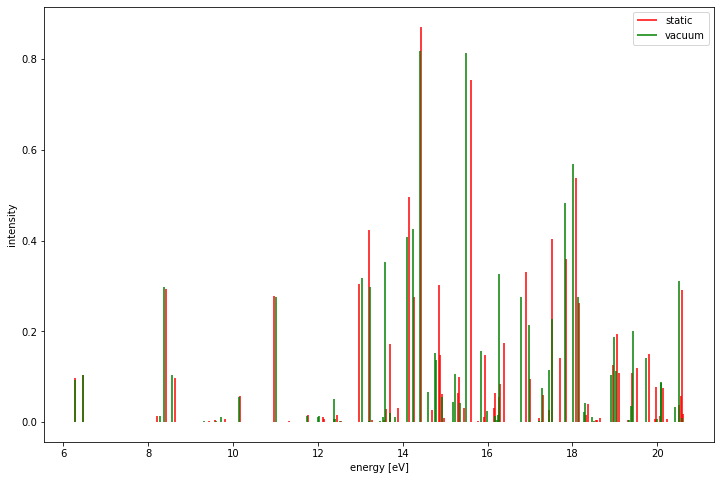

In [25]:
plt.vlines(spectrum_static[0],0,spectrum_static[1],label="static",color='r')
plt.vlines(spectrum_vacuum[0],0,spectrum_vacuum[1],label="vacuum",color='g')
plt.xlabel("energy [eV]")
plt.ylabel("intensity")
plt.legend()
plt.show()